In [1]:
import pandas as pd
import numpy as np
import math
import h5py
import tempfile

import tensorflow as tf
import tensorflow_model_optimization as tfmot
from sklearn.model_selection import train_test_split
print(tf.__version__)
from tensorflow.keras.models import Sequential, Model,model_from_json
from keras.layers import (InputLayer,Dense, Activation, BatchNormalization, 
                          Conv1D, Flatten, MaxPooling1D,AveragePooling1D)
from keras import initializers, regularizers, optimizers, losses
from nn_globals import *
from nn_encode_displ import nlayers, nvariables
from nn_models import (lr_decay, modelbestcheck, modelbestcheck_weights)
from nn_training import train_model
from nn_models import load_my_model, update_keras_custom_objects
from keras.models import Model
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')

from nn_plotting import (gaus, fit_gaus, np_printoptions, \
                         find_efficiency_errors)

eps = 1e-7
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)
my_palette = ("#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a")

[INFO    ] Using numpy 1.21.0
[INFO    ] Using tensorflow 2.4.1
[INFO    ] Using keras 2.4.3
[INFO    ] Using scipy 1.7.0
[INFO    ] Using sklearn 0.24.2


2.4.1


<ipython-input-1-0b946e0a86eb>:31: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  my_cmap.set_under('w',1)


In [2]:
class evaluate:
    def __init__(self,X_test,y_test):
        self.X = X_test
        self.y = y_test[0]
        self.dxy = y_test[1]
    
    def compute_data_statistics(self,ctype = "y",label="data"):
        if ctype == "y":
            x = self.recalibrate(self.y,reg_pt_scale)
            x = x**(-1)
        else:
            x = self.recalibrate(self.dxy,reg_dxy_scale)
        df_describe = pd.DataFrame(x, columns = [label])
        print(df_describe.describe())
    
    def rmse(self,y_true, y_predicted):
        assert(y_true.shape[0] == y_predicted.shape[0])
        n = y_true.shape[0]
        sum_square = np.sum((y_true - y_predicted)**2)
        return math.sqrt(sum_square/n)
    
    def adjusted_r_2(self,y_true, y_predicted):
        y_addC = sm.add_constant(y_true)
        result = sm.OLS(y_predicted, y_addC).fit()
        print(result.rsquared, result.rsquared_adj)

    def recalibrate(self,x,scale):
        return x/scale
    
    def inverse(self,arr):
        arr_inv = 1./arr
        arr_inv[arr_inv == np.inf] = 0.
        return arr_inv
    
    def predict(self,model,batch_size = 256):
        y_test_true = self.recalibrate(self.y,reg_pt_scale)
        dxy_test_true = self.recalibrate(self.dxy, reg_dxy_scale)
        
        y_test = model.predict(self.X,batch_size = 2000)
        y_test_meas = y_test[:,0]
        dxy_test_meas = y_test[:,1]
        y_test_meas = self.recalibrate(y_test_meas,reg_pt_scale)
        dxy_test_meas = self.recalibrate(dxy_test_meas,reg_dxy_scale)   
    
        y_test_meas = y_test_meas.reshape(-1)
        dxy_test_meas = dxy_test_meas.reshape(-1)

        return y_test_meas, dxy_test_meas
    
    def compute_error(self,y_predicted,ctype = "y"):
        if ctype == "y":
            y_test_true = self.recalibrate(self.y,reg_pt_scale)
            print("RMSE Error for momentum:",self.rmse(self.inverse(y_test_true),\
                                                                              self.inverse(y_predicted)))
        else:
            dxy_test_true = self.recalibrate(self.dxy, reg_dxy_scale)
            print("RMSE Error for dxy:",self.rmse(dxy_test_true,y_predicted))

    def get_error(self,y_predicted,ctype = "y"):
        if ctype == "y":
            y_test_true = self.recalibrate(self.y,reg_pt_scale)
            return self.rmse(self.inverse(y_test_true),self.inverse(y_predicted))
        else:
            dxy_test_true = self.recalibrate(self.dxy, reg_dxy_scale)
            return self.rmse(dxy_test_true,y_predicted)

def k_fold_validation(model, x, y, dxy, folds =10):
    x_copy = np.copy(x)
    y_copy = np.copy(y)
    dxy_copy = np.copy(dxy)
    assert x_copy.shape[0] == y_copy.shape[0] == dxy_copy.shape[0]
    fold_size = int(x_copy.shape[0] / folds)
    x_splits, y_splits, dxy_splits = [], [], []
    for i in range(folds):
        indices = np.random.choice(x_copy.shape[0],fold_size, replace=False)  
        x_splits.append(x_copy[indices])
        y_splits.append(y_copy[indices])
        dxy_splits.append(dxy_copy[indices])
        x_copy = np.delete(x_copy,indices,axis = 0)
        y_copy = np.delete(y_copy,indices,axis = 0)
        dxy_copy = np.delete(dxy_copy,indices,axis = 0)
    rmse_y, rmse_dxy = [],[]
    for i in range(folds):
        evaluate_obj = evaluate(x_splits[i], tuple([y_splits[i],dxy_splits[i]]))
        y_predicted , dxy_predicted = evaluate_obj.predict(model = model)
        rmse_y.append(evaluate_obj.get_error(y_predicted,ctype="y"))
        rmse_dxy.append(evaluate_obj.get_error(dxy_predicted,ctype="dxy"))
    print('Average RMSE for '+ str(folds) + '-fold cv for y:', np.mean(rmse_y))
    print('Average RMSE for '+ str(folds) + '-fold cv for dxy:', np.mean(rmse_dxy))

### Preprocessing the inputs:

In [3]:
infile_muon_displ = "NN_input_params_FlatXYZ.npz"

nentries = 100000000

def _handle_nan_in_x(x):
    x[np.isnan(x)] = 0.0
    x[x==-999.0] = 0.0
    return x

def _zero_out_x(x):
    x = 0.0
    return x
    
def _fixME1Ring(x):
    for i in range(len(x)):
        if (x[i,0] != 0.0): x[i,18] = x[i,18] + 1
    return x   

def muon_data(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, correct_for_eta=False):
    try:
        logger.info('Loading muon data from {0} ...'.format(filename))
        loaded = np.load(filename)
        the_variables = loaded['variables']
        the_parameters = loaded['parameters']
        # print(the_variables.shape)
        the_variables = the_variables[:nentries]
        the_parameters = the_parameters[:nentries]
        logger.info('Loaded the variables with shape {0}'.format(the_variables.shape))
        logger.info('Loaded the parameters with shape {0}'.format(the_parameters.shape))
    except:
        logger.error('Failed to load data from file: {0}'.format(filename))

    assert(the_variables.shape[0] == the_parameters.shape[0])
    _handle_nan_in_x(the_variables)
      #_fixME1Ring(the_variables)
    _handle_nan_in_x(the_parameters)
    mask = np.logical_or(np.logical_or( np.logical_or((the_variables[:,23] == 11), (the_variables[:,23] == 13)), (the_variables[:,23] == 14)),(the_variables[:,23] == 15)) 

    the_variables = the_variables[mask]  
    the_parameters = the_parameters[mask]  
    assert(the_variables.shape[0] == the_parameters.shape[0])

    x = the_variables[:,0:23]
    y = reg_pt_scale*the_parameters[:,0]
    phi = the_parameters[:,1] 
    eta = the_parameters[:,2] 
    vx = the_parameters[:,3] 
    vy = the_parameters[:,4] 
    vz = the_parameters[:,5]      
    dxy = vy * np.cos(phi) - vx * np.sin(phi) 
    dz = vz
    w = np.abs(y)/0.2 + 1.0
    x_mask = the_parameters[:,5]
    x_road = the_parameters[:,5] 
    _zero_out_x(x_mask)
    _zero_out_x(x_road)  
    logger.info('Loaded the encoded variables with shape {0}'.format(x.shape))
    logger.info('Loaded the encoded parameters with shape {0}'.format(y.shape))
    #assert(np.isfinite(x).all())
    return x, y, dxy, dz, w, x_mask, x_road

def muon_data_split(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, test_size=0.5, correct_for_eta=False):
    x, y, dxy, dz, w, x_mask, x_road = muon_data(filename, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, correct_for_eta=correct_for_eta)

    # Split dataset in training and testing
    x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = train_test_split(x, y, dxy, dz, w, x_mask, x_road, test_size=test_size)
    logger.info('Loaded # of training and testing events: {0}'.format((x_train.shape[0], x_test.shape[0])))

    # Check for cases where the number of events in the last batch could be too few
    validation_split = 0.1
    train_num_samples = int(x_train.shape[0] * (1.0-validation_split))
    val_num_samples = x_train.shape[0] - train_num_samples
    batch_size = 128
    if (train_num_samples%batch_size) < 100:
        logger.warning('The last batch for training could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
        logger.warning('Try this formula: int(int({0}*{1})*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
    train_num_samples = int(x_train.shape[0] * 2 * (1.0-validation_split))
    val_num_samples = x_train.shape[0] - train_num_samples
    batch_size = 128
    if (train_num_samples%batch_size) < 100:
        logger.warning('The last batch for training after mixing could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
        logger.warning('Try this formula: int(int({0}*{1})*2*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
    return x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test

# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT
x_train_displ, x_test_displ, y_train_displ, y_test_displ, dxy_train_displ, dxy_test_displ, dz_train_displ, dz_test_displ, \
w_train_displ, w_test_displ, x_mask_train_displ, x_mask_test_displ, x_road_train_displ, x_road_test_displ = \
      muon_data_split(infile_muon_displ, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, test_size=0.315)

y_train_displ = np.abs(y_train_displ)
y_test_displ = np.abs(y_test_displ)


[INFO    ] Loading muon data from NN_input_params_FlatXYZ.npz ...
[INFO    ] Loaded the variables with shape (19300000, 25)
[INFO    ] Loaded the parameters with shape (19300000, 6)
[INFO    ] Loaded the encoded variables with shape (3284620, 23)
[INFO    ] Loaded the encoded parameters with shape (3284620,)
[INFO    ] Loaded # of training and testing events: (2249964, 1034656)
[WARNING ] The last batch for training could be too few! (2024967%128)=7. Please change test_size.
[WARNING ] Try this formula: int(int(3284620*0.685)*0.9) % 128
[WARNING ] The last batch for training after mixing could be too few! (4049935%128)=15. Please change test_size.
[WARNING ] Try this formula: int(int(3284620*0.685)*2*0.9) % 128


In [4]:
# Reshape to add a channel for convolution
x_train_displ = x_train_displ.reshape((x_train_displ.shape[0],23,1))
x_test_displ = x_test_displ.reshape((x_test_displ.shape[0],23,1))
print(x_train_displ.shape,x_test_displ.shape)

(2249964, 23, 1) (1034656, 23, 1)


In [5]:
x = np.concatenate((x_train_displ, x_test_displ),axis = 0)
y = np.concatenate((y_train_displ, y_test_displ),axis = 0)
dxy = np.concatenate((dxy_train_displ, dxy_test_displ),axis = 0)

### Pre- quantization model analysis:

In [6]:
def huber_loss(y_true, y_pred, delta=1.345):
    x = K.abs(y_true - y_pred)
    squared_loss = 0.5*K.square(x)
    absolute_loss = delta * (x - 0.5*delta)
    #xx = K.switch(x < delta, squared_loss, absolute_loss)
    xx = tf.where(x < delta, squared_loss, absolute_loss)  # needed for tensorflow
    return K.mean(xx, axis=-1)

In [7]:
def add_conv_module(model, 
                    filters, 
                    kernel_size = 3, 
                    pool_size = 3, 
                    stride = 1,
                    padding = "valid", 
                    regularizer = None,
                    use_pooling = True, 
                    use_batchnorm = True, 
                    kernel_initializer = None):
    
    model.add(Conv1D(filters=filters, 
                     kernel_size=kernel_size, 
                     strides = stride,
                     padding = padding, 
                     kernel_initializer=kernel_initializer,
                     kernel_regularizer = regularizer))
    if use_batchnorm:
        model.add(BatchNormalization(epsilon=1e-4, 
                                     momentum=0.9))    
    if use_pooling:
        model.add(MaxPooling1D(pool_size = pool_size, 
                               padding = padding))  
    model.add(Activation("relu"))
    return model 

def create_conv_model(nvariables, 
                      lr=0.001, 
                      clipnorm=10., 
                      outnodes=2,
                      l1_reg=0.0, 
                      l2_reg=0.0, 
                      kernel_initializer = None):
    
    regularizer = regularizers.L1L2(l1=l1_reg, l2=l2_reg)
    
    model = Sequential()  
    model.add(InputLayer(input_shape=(nvariables,1)))
    model = add_conv_module(model,filters = 15, 
                           kernel_size =2, 
                           pool_size = 2, 
                           regularizer = regularizer,
                           kernel_initializer = kernel_initializer)
    model = add_conv_module(model,filters = 10, 
                           kernel_size =2, 
                           pool_size = 2, 
                           regularizer = regularizer,
                           kernel_initializer = kernel_initializer)
    model = add_conv_module(model,filters = 5, 
                           kernel_size =2, 
                           pool_size = 2, 
                           regularizer = regularizer,
                           kernel_initializer=kernel_initializer)
    
    model.add(Flatten())
    # Output node
    model.add(Dense(outnodes, activation='linear', kernel_initializer=kernel_initializer))
    # Set loss and optimizers
    adam = optimizers.Adam(lr=lr, clipnorm=clipnorm)
    model.compile(optimizer=adam, loss=huber_loss, metrics=['acc'])
    model.summary()
    return model

In [8]:
assert(keras.backend.backend() == 'tensorflow')

gradient_clip_norm = 10.
l1_reg = 0.0
l2_reg = 0.0
lr = 1e-3
model = create_conv_model(nvariables=nvariables, 
                          lr=lr, 
                          clipnorm=gradient_clip_norm,
                          l1_reg=l1_reg, 
                          l2_reg=l2_reg, 
                          outnodes=2, 
                          kernel_initializer = "he_uniform")

logger.info('Training model with l1_reg: {0} l2_reg: {1}'.format(l1_reg, l2_reg))
normal_epochs = 300
normal_batch_size = 1000

history = train_model(model, x_train_displ, np.column_stack((y_train_displ, dxy_train_displ)),
                    save_model=False, epochs=normal_epochs, batch_size=normal_batch_size,
                    callbacks=[lr_decay,
                               modelbestcheck,
                               modelbestcheck_weights], validation_split=0.2, verbose=2)

metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]]
logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(*metrics))

[INFO    ] Training model with l1_reg: 0.0 l2_reg: 0.0
[INFO    ] Begin training ...


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 22, 15)            45        
_________________________________________________________________
batch_normalization (BatchNo (None, 22, 15)            60        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 15)            0         
_________________________________________________________________
activation (Activation)      (None, 11, 15)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 10)            310       
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10)            40        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 10)             0

1800/1800 - 15s - loss: 13.8846 - acc: 0.9158 - val_loss: 13.9636 - val_acc: 0.9163

Epoch 00020: val_loss did not improve from 13.83368

Epoch 00020: val_loss did not improve from 13.83368
Epoch 21/300

Epoch 00021: LearningRateScheduler reducing learning rate to 0.0008100000384729356.
1800/1800 - 15s - loss: 13.8556 - acc: 0.9159 - val_loss: 13.7705 - val_acc: 0.9151

Epoch 00021: val_loss improved from 13.83368 to 13.77052, saving model to model_bchk.h5

Epoch 00021: val_loss improved from 13.83368 to 13.77052, saving model to model_bchk_weights.h5
Epoch 22/300

Epoch 00022: LearningRateScheduler reducing learning rate to 0.0008100000559352338.
1800/1800 - 15s - loss: 13.8458 - acc: 0.9160 - val_loss: 14.5008 - val_acc: 0.9141

Epoch 00022: val_loss did not improve from 13.77052

Epoch 00022: val_loss did not improve from 13.77052
Epoch 23/300

Epoch 00023: LearningRateScheduler reducing learning rate to 0.0008100000559352338.
1800/1800 - 15s - loss: 13.8326 - acc: 0.9163 - val_loss

1800/1800 - 15s - loss: 13.6478 - acc: 0.9174 - val_loss: 13.6066 - val_acc: 0.9177

Epoch 00047: val_loss did not improve from 13.48656

Epoch 00047: val_loss did not improve from 13.48656
Epoch 48/300

Epoch 00048: LearningRateScheduler reducing learning rate to 0.0006561000482179224.
1800/1800 - 15s - loss: 13.6456 - acc: 0.9172 - val_loss: 13.7022 - val_acc: 0.9136

Epoch 00048: val_loss did not improve from 13.48656

Epoch 00048: val_loss did not improve from 13.48656
Epoch 49/300

Epoch 00049: LearningRateScheduler reducing learning rate to 0.0006561000482179224.
1800/1800 - 15s - loss: 13.6469 - acc: 0.9172 - val_loss: 13.4782 - val_acc: 0.9176

Epoch 00049: val_loss improved from 13.48656 to 13.47824, saving model to model_bchk.h5

Epoch 00049: val_loss improved from 13.48656 to 13.47824, saving model to model_bchk_weights.h5
Epoch 50/300

Epoch 00050: LearningRateScheduler reducing learning rate to 0.0006561000482179224.
1800/1800 - 15s - loss: 13.6380 - acc: 0.9174 - val_loss

1800/1800 - 17s - loss: 13.5742 - acc: 0.9176 - val_loss: 13.5225 - val_acc: 0.9166

Epoch 00075: val_loss did not improve from 13.39731

Epoch 00075: val_loss did not improve from 13.39731
Epoch 76/300

Epoch 00076: LearningRateScheduler reducing learning rate to 0.00047829694813117385.
1800/1800 - 16s - loss: 13.5860 - acc: 0.9177 - val_loss: 13.6039 - val_acc: 0.9155

Epoch 00076: val_loss did not improve from 13.39731

Epoch 00076: val_loss did not improve from 13.39731
Epoch 77/300

Epoch 00077: LearningRateScheduler reducing learning rate to 0.00047829694813117385.
1800/1800 - 16s - loss: 13.5755 - acc: 0.9178 - val_loss: 13.3811 - val_acc: 0.9193

Epoch 00077: val_loss improved from 13.39731 to 13.38113, saving model to model_bchk.h5

Epoch 00077: val_loss improved from 13.39731 to 13.38113, saving model to model_bchk_weights.h5
Epoch 78/300

Epoch 00078: LearningRateScheduler reducing learning rate to 0.00047829694813117385.
1800/1800 - 16s - loss: 13.5784 - acc: 0.9177 - val_l

1800/1800 - 15s - loss: 13.5424 - acc: 0.9181 - val_loss: 13.6130 - val_acc: 0.9161

Epoch 00103: val_loss did not improve from 13.34494

Epoch 00103: val_loss did not improve from 13.34494
Epoch 104/300

Epoch 00104: LearningRateScheduler reducing learning rate to 0.0003486784698907286.
1800/1800 - 15s - loss: 13.5326 - acc: 0.9184 - val_loss: 13.6038 - val_acc: 0.9153

Epoch 00104: val_loss did not improve from 13.34494

Epoch 00104: val_loss did not improve from 13.34494
Epoch 105/300

Epoch 00105: LearningRateScheduler reducing learning rate to 0.0003486784698907286.
1800/1800 - 15s - loss: 13.5373 - acc: 0.9181 - val_loss: 14.0882 - val_acc: 0.9100

Epoch 00105: val_loss did not improve from 13.34494

Epoch 00105: val_loss did not improve from 13.34494
Epoch 106/300

Epoch 00106: LearningRateScheduler reducing learning rate to 0.0003486784698907286.
1800/1800 - 15s - loss: 13.5436 - acc: 0.9182 - val_loss: 13.9708 - val_acc: 0.9112

Epoch 00106: val_loss did not improve from 13.34

1800/1800 - 15s - loss: 13.5136 - acc: 0.9184 - val_loss: 13.7063 - val_acc: 0.9145

Epoch 00132: val_loss did not improve from 13.34494

Epoch 00132: val_loss did not improve from 13.34494
Epoch 133/300

Epoch 00133: LearningRateScheduler reducing learning rate to 0.00025418659788556397.
1800/1800 - 15s - loss: 13.5042 - acc: 0.9187 - val_loss: 13.3547 - val_acc: 0.9192

Epoch 00133: val_loss did not improve from 13.34494

Epoch 00133: val_loss did not improve from 13.34494
Epoch 134/300

Epoch 00134: LearningRateScheduler reducing learning rate to 0.00025418659788556397.
1800/1800 - 15s - loss: 13.5053 - acc: 0.9187 - val_loss: 13.3665 - val_acc: 0.9196

Epoch 00134: val_loss did not improve from 13.34494

Epoch 00134: val_loss did not improve from 13.34494
Epoch 135/300

Epoch 00135: LearningRateScheduler reducing learning rate to 0.00025418659788556397.
1800/1800 - 15s - loss: 13.5119 - acc: 0.9186 - val_loss: 13.4342 - val_acc: 0.9173

Epoch 00135: val_loss did not improve from 13

1800/1800 - 15s - loss: 13.4924 - acc: 0.9187 - val_loss: 13.3744 - val_acc: 0.9194

Epoch 00160: val_loss did not improve from 13.30495

Epoch 00160: val_loss did not improve from 13.30495
Epoch 161/300

Epoch 00161: LearningRateScheduler reducing learning rate to 0.00018530203378759326.
1800/1800 - 15s - loss: 13.4895 - acc: 0.9188 - val_loss: 13.3344 - val_acc: 0.9199

Epoch 00161: val_loss did not improve from 13.30495

Epoch 00161: val_loss did not improve from 13.30495
Epoch 162/300

Epoch 00162: LearningRateScheduler reducing learning rate to 0.0001853020366979763.
1800/1800 - 17s - loss: 13.4879 - acc: 0.9188 - val_loss: 13.3356 - val_acc: 0.9186

Epoch 00162: val_loss did not improve from 13.30495

Epoch 00162: val_loss did not improve from 13.30495
Epoch 163/300

Epoch 00163: LearningRateScheduler reducing learning rate to 0.0001853020366979763.
1800/1800 - 16s - loss: 13.4892 - acc: 0.9187 - val_loss: 13.3948 - val_acc: 0.9194

Epoch 00163: val_loss did not improve from 13.3


Epoch 00188: val_loss did not improve from 13.30322

Epoch 00188: val_loss did not improve from 13.30322
Epoch 189/300

Epoch 00189: LearningRateScheduler reducing learning rate to 0.000150094652781263.
1800/1800 - 16s - loss: 13.4746 - acc: 0.9189 - val_loss: 13.3150 - val_acc: 0.9196

Epoch 00189: val_loss did not improve from 13.30322

Epoch 00189: val_loss did not improve from 13.30322
Epoch 190/300

Epoch 00190: LearningRateScheduler reducing learning rate to 0.000150094652781263.
1800/1800 - 16s - loss: 13.4831 - acc: 0.9188 - val_loss: 13.3236 - val_acc: 0.9198

Epoch 00190: val_loss did not improve from 13.30322

Epoch 00190: val_loss did not improve from 13.30322
Epoch 191/300

Epoch 00191: LearningRateScheduler reducing learning rate to 0.0001350851875031367.
1800/1800 - 15s - loss: 13.4698 - acc: 0.9189 - val_loss: 13.7509 - val_acc: 0.9133

Epoch 00191: val_loss did not improve from 13.30322

Epoch 00191: val_loss did not improve from 13.30322
Epoch 192/300

Epoch 00192: L

1800/1800 - 16s - loss: 13.4673 - acc: 0.9190 - val_loss: 13.3094 - val_acc: 0.9202

Epoch 00217: val_loss did not improve from 13.29850

Epoch 00217: val_loss did not improve from 13.29850
Epoch 218/300

Epoch 00218: LearningRateScheduler reducing learning rate to 0.00010941899381577969.
1800/1800 - 16s - loss: 13.4666 - acc: 0.9187 - val_loss: 13.3046 - val_acc: 0.9193

Epoch 00218: val_loss did not improve from 13.29850

Epoch 00218: val_loss did not improve from 13.29850
Epoch 219/300

Epoch 00219: LearningRateScheduler reducing learning rate to 0.00010941899381577969.
1800/1800 - 16s - loss: 13.4703 - acc: 0.9189 - val_loss: 13.3187 - val_acc: 0.9195

Epoch 00219: val_loss did not improve from 13.29850

Epoch 00219: val_loss did not improve from 13.29850
Epoch 220/300

Epoch 00220: LearningRateScheduler reducing learning rate to 0.00010941899381577969.
1800/1800 - 17s - loss: 13.4659 - acc: 0.9190 - val_loss: 13.2943 - val_acc: 0.9200

Epoch 00220: val_loss improved from 13.29850 

1800/1800 - 15s - loss: 13.4587 - acc: 0.9190 - val_loss: 13.2987 - val_acc: 0.9197

Epoch 00245: val_loss did not improve from 13.28874

Epoch 00245: val_loss did not improve from 13.28874
Epoch 246/300

Epoch 00246: LearningRateScheduler reducing learning rate to 7.976644701557234e-05.
1800/1800 - 15s - loss: 13.4501 - acc: 0.9190 - val_loss: 13.3147 - val_acc: 0.9190

Epoch 00246: val_loss did not improve from 13.28874

Epoch 00246: val_loss did not improve from 13.28874
Epoch 247/300

Epoch 00247: LearningRateScheduler reducing learning rate to 7.976644701557234e-05.
1800/1800 - 15s - loss: 13.4529 - acc: 0.9191 - val_loss: 13.3363 - val_acc: 0.9197

Epoch 00247: val_loss did not improve from 13.28874

Epoch 00247: val_loss did not improve from 13.28874
Epoch 248/300

Epoch 00248: LearningRateScheduler reducing learning rate to 7.976644701557234e-05.
1800/1800 - 15s - loss: 13.4521 - acc: 0.9191 - val_loss: 13.2932 - val_acc: 0.9203

Epoch 00248: val_loss did not improve from 13.28

1800/1800 - 16s - loss: 13.4426 - acc: 0.9190 - val_loss: 13.2695 - val_acc: 0.9201

Epoch 00273: val_loss improved from 13.27373 to 13.26950, saving model to model_bchk.h5

Epoch 00273: val_loss improved from 13.27373 to 13.26950, saving model to model_bchk_weights.h5
Epoch 274/300

Epoch 00274: LearningRateScheduler reducing learning rate to 5.81497406528797e-05.
1800/1800 - 16s - loss: 13.4482 - acc: 0.9191 - val_loss: 13.2828 - val_acc: 0.9195

Epoch 00274: val_loss did not improve from 13.26950

Epoch 00274: val_loss did not improve from 13.26950
Epoch 275/300

Epoch 00275: LearningRateScheduler reducing learning rate to 5.81497406528797e-05.
1800/1800 - 16s - loss: 13.4433 - acc: 0.9192 - val_loss: 13.3048 - val_acc: 0.9190

Epoch 00275: val_loss did not improve from 13.26950

Epoch 00275: val_loss did not improve from 13.26950
Epoch 276/300

Epoch 00276: LearningRateScheduler reducing learning rate to 5.81497406528797e-05.
1800/1800 - 16s - loss: 13.4460 - acc: 0.9190 - val_loss

[INFO    ] Done training. Time elapsed: 1:17:20.677787 sec
[INFO    ] Epoch 300/300 - loss: 13.443351745605469 - val_loss: 13.275480270385742



Epoch 00300: val_loss did not improve from 13.26950

Epoch 00300: val_loss did not improve from 13.26950


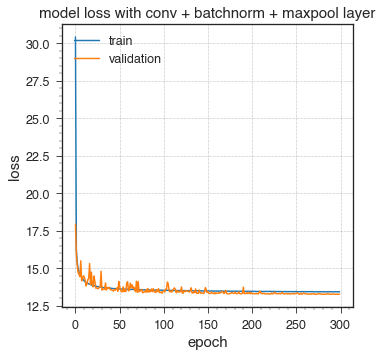

In [9]:
plt.figure(figsize=(5,5),dpi = 75)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with conv + batchnorm + maxpool layer')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
k_fold_validation(model = model, 
                  x = x, 
                  y = y, 
                  dxy = dxy, 
                  folds =50)

Average RMSE for 50-fold cv for y: 68.60650785255
Average RMSE for 50-fold cv for dxy: 20.98529124930171


In [11]:
training_params = {"epochs":normal_epochs, 
                   "batch size":normal_batch_size, 
                   "learning rate":lr,
                   "BN momentum":0.7,
                   "BN epsilon":1e-4,
                   "Kernel Initializer":"he_uniform",
                   "L1 Reg":l1_reg,
                   "L2 Reg":l2_reg
                  }
df = pd.DataFrame(training_params.items(), 
                  columns=['Training Parameters', 'Value'],
                  index = [i+1 for i in range(len(training_params))])
df

,Training Parameters,Value
1,epochs,300
2,batch size,1000
3,learning rate,0.001
4,BN momentum,0.7
5,BN epsilon,0.0001
6,Kernel Initializer,he_uniform
7,L1 Reg,0.0
8,L2 Reg,0.0


In [12]:
#################### END ############################################################################################